In [2]:
import os
import sys
import importlib
from pathlib import Path

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [3]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'


In [4]:
import string
import re
import time
import tqdm
import json
import csv
import glob
import pickle
import joblib
import random
import itertools
import unicodedata
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.feature_selection import (SelectFdr, SelectFpr,
                                       SelectFromModel, SelectFwe,
                                       SelectKBest, SelectPercentile, chi2,
                                       f_classif, f_regression,
                                       mutual_info_classif,
                                       mutual_info_regression)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import (LogisticRegression,
                                  PassiveAggressiveClassifier, Perceptron,
                                  SGDClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              BaggingRegressor, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              StackingRegressor, VotingClassifier,
                              VotingRegressor)
from sklearn.model_selection import (GridSearchCV, KFold, LeaveOneOut,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold, ShuffleSplit,
                                     StratifiedKFold,
                                     StratifiedShuffleSplit,
                                     cross_val_score, cross_validate,
                                     learning_curve, train_test_split)
from sklearn.utils.validation import (check_is_fitted, column_or_1d,
                                      has_fit_parameter)
from sklearn import feature_selection, metrics, set_config, svm, utils
from sklearn.metrics import (ConfusionMatrixDisplay,accuracy_score, balanced_accuracy_score,
                             brier_score_loss, classification_report, cohen_kappa_score,
                             confusion_matrix, f1_score, log_loss,
                             make_scorer, matthews_corrcoef,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
from sklearn.calibration import CalibrationDisplay
from sklearn.utils import (check_consistent_length, check_random_state, check_X_y)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import (EditedNearestNeighbours, NearMiss,
                                     RandomUnderSampler, TomekLinks)
from xgboost import XGBClassifier

In [6]:
# Validation split ratios
n_jobs = 1
train_ratio = 0.75
test_ratio = 0.10
validation_ratio = 0.15
test_split = test_size = 1 - train_ratio
validation_split = test_ratio / (test_ratio + validation_ratio)

# Cross-validation
random.seed(42)
np.random.seed(42)
random_state = 42
partition = True
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=random_state)
# Resampling
class_weight = 'balanced'
resampling_enabled = True
resample_enn = SMOTEENN(
    enn=EditedNearestNeighbours(sampling_strategy='majority'))
resample_tome = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# Undersampling
rus = RandomUnderSampler(random_state=random_state, replacement=True)
tl = RandomOverSampler(sampling_strategy='majority')
nm = NearMiss()
# Oversampling
ros = RandomOverSampler(random_state=random_state)
smote = SMOTE()
# Sampling Used
resampling_method = resample_tome

t = time.time()
cores = multiprocessing.cpu_count()
model_sizes = [300, 100]
scoring = 'recall'
scores = ['recall', 'accuracy', 'f1', 'roc_auc', 'explained_variance', 'matthews_corrcoef']
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
}
metrics_list = [
    'Mean Validation Score',
    'Explained Variance',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-score',
    'ROC',
    'AUC',
    'Matthews Correlation Coefficient',
    f'{scoring.title()} Best Threshold',
    f'{scoring.title()} Best Score',
    'Log Loss/Cross Entropy',
    'Classification Report',
    'Confusion Matrix',
]

# Paths
models_save_path = f'{data_dir}classification models/'
table_save_path = f'{data_dir}output tables/'
plot_save_path = f'{data_dir}plots/'

## Vectorizers

In [7]:
### CountVectorizer
count = CountVectorizer()
params_count_pipe = {
#     'TfidfVectorizer__stop_words': ['english'],
    'CountVectorizer__analyzer': ['word'],
    'CountVectorizer__ngram_range': [(1, 3)],
    'CountVectorizer__lowercase': [True, False],
    'CountVectorizer__max_df': [0.90, 0.85, 0.80, 0.75, 0.70],
    'CountVectorizer__min_df': [0.10, 0.15, 0.20, 0.25, 0.30],
}

### TfidfVectorizer
tfidf = TfidfVectorizer()
params_tfidf_pipe = {
#     'TfidfVectorizer__stop_words': ['english'],
    'TfidfVectorizer__analyzer': ['word'],
    'TfidfVectorizer__ngram_range': [(1, 3)],
    'TfidfVectorizer__lowercase': [True, False],
    'TfidfVectorizer___use_idf': [True, False],
    'TfidfVectorizer__max_df': [0.90, 0.85, 0.80, 0.75, 0.70],
    'TfidfVectorizer__min_df': [0.10, 0.15, 0.20, 0.25, 0.30],
}

### BOW FeatureUnion
bow = FeatureUnion(
    transformer_list=[('CountVectorizer', count), ('TfidfVectorizer', tfidf)]
)
params_bow_pipe = {**params_count_pipe, **params_tfidf_pipe}

## Vectorizers Dict
vectorizers_pipe = {
    'CountVectorizer': [count, params_count_pipe],
    'TfidfVectorizer': [tfidf, params_tfidf_pipe],
    'UnionBOW': [bow, params_bow_pipe],
    # "UnionWordEmbedding": [em, params_em_pipe],
}


## Selectors

In [8]:
### SelectKBest
selectkbest = SelectKBest()
params_selectkbest_pipe = {
    'SelectKBest__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
    'SelectKBest__k': ['all'],
}

### SelectPercentile
selectpercentile = SelectPercentile()
params_selectpercentile_pipe = {
    'SelectPercentile__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
    'SelectPercentile__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

### SelectFpr
selectfpr = SelectFpr()
params_selectfpr_pipe = {
    'SelectFpr__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}

### SelectFdr
selectfdr = SelectFdr()
params_selectfdr_pipe = {
    'SelectFdr__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}

### SelectFwe
selectfwe = SelectFwe()
params_selectfwe_pipe = {
    'SelectFwe__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}

## Selectors Dict
selectors_pipe = {
    'SelectKBest': [selectkbest, params_selectkbest_pipe],
    'SelectPercentile': [selectpercentile, params_selectpercentile_pipe],
    'SelectFpr': [selectfpr, params_selectfpr_pipe],
    'SelectFdr': [selectfdr, params_selectfdr_pipe],
    'SelectFwe': [selectfwe, params_selectfwe_pipe],
}

## Classifiers

In [9]:
# Classifiers
### Dummy Classifier
dummy = DummyClassifier()
params_dummy_freq = {'strategy': 'most_frequent', 'random_state': random_state}
params_dummy_stratified = {'strategy': 'stratified', 'random_state': random_state}
params_dummy_uniform = {'strategy': 'uniform', 'random_state': random_state}
params_dummy_pipe = {
    'DummyClassifier__strategy': [
        'stratified',
        'most_frequent',
        'prior',
        'uniform',
    ],
    'DummyClassifier__random_state': [random_state],
}

### Multinomial Naive Bayes
nb = MultinomialNB()
params_nb = {'alpha': 0.1, 'fit_prior': True, 'class_prior': None}
params_nb_pipe = {
    'MultinomialNB__fit_prior': [True],
    'MultinomialNB__alpha': [0.1, 0.2, 0.3],
}

### Bernoulli Naive Bayes
bnb = BernoulliNB()
params_bnb = {'alpha': 0.1, 'fit_prior': True, 'class_prior': None}
params_bnb_pipe = {
    'BernoulliNB__fit_prior': [True],
    'BernoulliNB__alpha': [0.1, 0.2, 0.3],
}

### Gaussian Naive Bayes
gnb = GaussianNB()
params_gnb = {'var_smoothing': 1e-9}
params_gnb_pipe = {
    'GaussianNB__var_smoothing': [1e-9],
}

### KNeighbors Classifier
knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': 3,
    'weights': 'uniform',
    'algorithm': 'auto',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': 1,
}
params_knn_pipe = {
    'KNeighborsClassifier__weights': ['uniform'],
    'KNeighborsClassifier__n_neighbors': [2, 5, 15],
    'KNeighborsClassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'KNeighborsClassifier__leaf_size': [30, 50, 100, 200, 300, 500],
    'KNeighborsClassifier__p': [1, 2, 3, 4, 5],
    'KNeighborsClassifier__metric': [
        'minkowski',
        'euclidean',
        'cosine',
        'correlation',
    ],
    'KNeighborsClassifier__metric_params': [None, {'p': 2}, {'p': 3}],
}

### Logistic Regression
lr = LogisticRegression()
params_lr = {
    'penalty': 'l2',
    'dual': False,
    'tol': 0.0001,
    'C': 1.0,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'class_weight': class_weight,
    'random_state': random_state,
    'solver': 'liblinear',
    'max_iter': 100,
    'multi_class': 'ovr',
    'verbose': 0,
    'warm_start': False,
    'n_jobs': 1,
}
params_lr_pipe = {
    'LogisticRegression__penalty': ['l2'],
    'LogisticRegression__random_state': [random_state],
    'LogisticRegression__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'LogisticRegression__max_iter': [100, 200, 300, 500, 1000],
    'LogisticRegression__multi_class': ['ovr', 'multinomial'],
    'LogisticRegression__solver': ['newton-cg', 'liblinear'],
    'LogisticRegression__C': [0.01, 1, 100],
}

### Passive Aggressive
pa = PassiveAggressiveClassifier()
params_pa = {
    'C': 1.0,
    'fit_intercept': True,
    'max_iter': 1000,
    'tol': 0.0001,
    'class_weight': class_weight,
    'verbose': 0,
    'random_state': random_state,
    'loss': 'hinge',
    'n_jobs': 1,
}
params_pa_pipe = {
    'PassiveAggressiveClassifier__loss': ['hinge', 'squared_hinge'],
    'PassiveAggressiveClassifier__random_state': [random_state],
    'PassiveAggressiveClassifier__fit_intercept': [True, False],
    'PassiveAggressiveClassifier__class_weight': [None, 'balanced'],
    'PassiveAggressiveClassifier__max_iter': [100, 200, 300, 500, 1000],
}

### Stochastic Gradient Descent Aggressive
sgd = SGDClassifier()
params_sgd = {
    'fit_intercept': True,
    'max_iter': 1000,
    'tol': 0.0001,
    'class_weight': class_weight,
    'verbose': 0,
    'random_state': random_state,
    'loss': 'hinge',
    'n_jobs': 1,
}
params_sgd_pipe = {
    'SGDClassifier__loss': ['hinge', 'squared_hinge'],
    'SGDClassifier__random_state': [random_state],
    'SGDClassifier__fit_intercept': [True, False],
    'SGDClassifier__class_weight': [None, 'balanced'],
    'SGDClassifier__max_iter': [100, 200, 300, 500, 1000],
}

### SVM
svm = LinearSVC()
params_svm = {
    'penalty': 'l2',
    'loss': 'hinge',
    'dual': True,
    'tol': 0.0001,
    'C': 1.0,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'class_weight': class_weight,
    'random_state': random_state,
    'max_iter': 1000,
    'multi_class': 'ovr',
    'verbose': 0,
}
params_svm_pipe = {
    'LinearSVC__penalty': ['l2'],
    'LinearSVC__loss': ['hinge', 'squared_hinge'],
    'LinearSVC__random_state': [random_state],
    'LinearSVC__max_iter': [100, 200, 300, 500, 1000],
    'LinearSVC__fit_intercept': [True, False],
    'LinearSVC__class_weight': [None, 'balanced'],
    'LinearSVC__multi_class': ['ovr', 'crammer_singer'],
}

### Decision Tree
dt = DecisionTreeClassifier()
params_dt = {
    'criterion': 'gini',
    'splitter': 'best',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,
    'random_state': random_state,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
}
params_dt_pipe = {
    'DecisionTreeClassifier__max_depth': [5, 10],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy'],
    'DecisionTreeClassifier__random_state': [random_state],
    'DecisionTreeClassifier__splitter': ['best', 'random'],
    'DecisionTreeClassifier__max_features': [None, 'auto', 'sqrt', 'log2'],
}

### Random Forest
rf = RandomForestClassifier()
params_rf = {
    'n_estimators': 10,
    'criterion': 'log_loss',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': True,
    'n_jobs': 1,
    'random_state': random_state,
    'verbose': 0,
    'warm_start': False,
    'class_weight': class_weight,
}
params_rf_pipe = {
    'RandomForestClassifier__n_estimators': [10, 20],
    'RandomForestClassifier__n_jobs': [-1],
    'RandomForestClassifier__max_depth': [5, 10],
    'RandomForestClassifier__max_feature': [*np.arange(0.1, 1.1, 0.1)],
    'RandomForestClassifier__random_state': [random_state],
    'RandomForestClassifier__class_weight': [None, 'balanced'],
    'RandomForestClassifier__oob_score': [True],
}

### Extra Trees
et = ExtraTreesClassifier()
params_et = {
    'n_estimators': 10,
    'criterion': 'log_loss',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': 1,
    'random_state': random_state,
    'verbose': 0,
    'warm_start': False,
    'class_weight': class_weight,
}
params_et_pipe = {
    'ExtraTreesClassifier__n_estimators': [10, 20],
    'ExtraTreesClassifier__n_jobs': [-1],
    'ExtraTreesClassifier__max_depth': [5, 10],
    'ExtraTreesClassifier__max_feature': [*np.arange(0.1, 1.1, 0.1)],
    'ExtraTreesClassifier__random_state': [random_state],
    'ExtraTreesClassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'ExtraTreesClassifier__class_weight': [None, 'balanced'],
}

### Gradient Boosting
gbc = GradientBoostingClassifier()
params_gbc = {
    'loss': 'deviance',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 1.0,
    'criterion': 'friedman_mse',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_depth': 3,
    'min_impurity_decrease': 0.0,
    'init': None,
    'random_state': random_state,
    'max_features': None,
    'verbose': 0,
    'max_leaf_nodes': None,
    'warm_start': False,
}
params_gbc_pipe = {
    'GradientBoostingClassifier__max_depth': [5, 10],
    'GradientBoostingClassifier__criterion': ['gini', 'entropy'],
    'GradientBoostingClassifier__random_state': [random_state],
    'GradientBoostingClassifier__n_estimators': [10, 20],
    'GradientBoostingClassifier__loss': ['deviance', 'exponential'],
    'GradientBoostingClassifier__subsample': [*np.arange(0.1, 1.1, 0.1)],
    'GradientBoostingClassifier__max_features': [None, 'auto', 'sqrt', 'log2'],
}

### AdaBoost
ada = AdaBoostClassifier()
params_ada = {
    'base_estimator': None,
    'n_estimators': 50,
    'learning_rate': 1.0,
    'algorithm': 'SAMME.R',
    'random_state': random_state,
}
params_ada_pipe = {
    'AdaBoostClassifier__max_depth': [5, 10],
    'AdaBoostClassifier__criterion': ['gini', 'entropy'],
    'AdaBoostClassifier__random_state': [random_state],
    'AdaBoostClassifier__n_estimators': [50, 100, 150],
    'AdaBoostClassifier__base_estimator': [
        SVC(probability=True, kernel='linear'),
        LogisticRegression(),
        MultinomialNB(),
    ],
}

### XGBoost
xgb = XGBClassifier()
params_xgb = {
    'nthread':4, #when use hyperthread, xgboost may become slower
    'objective':'binary:logistic',
    'learning_rate': 0.05, #so called `eta` value
    'max_depth': 6,
    'min_child_weight': 11,
    'silent': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_estimators': 1000, #number of trees, change it to 1000 for better results
    'missing':-999,
    'seed': 1337,
    'eval_metric': 'auc',
    'sample_type': 'weighted',
    'verbosity': '0',
}
params_xgb_pipe = {
    'xgb__max_depth': [5, 10],
    'xgb__learning_rate': [0.05],
    'xgb__n_estimators': [1000],
    'xgb__seed': [42],
    'xgb__nthread': [1, 2, 3, 4],
    'xgb__objective': ['binary:logitraw', 'binary:logistic', 'binary:hinge'],
    'xgb__eval_metric': ['auc', 'rmse', 'rmsle', 'logloss'],
    'xgb__sample_type': ['weighted', 'uniform'],
}

### MLP Classifier
mlpc = MLPClassifier()
params_mlpc = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'batch_size': 'auto',
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'power_t': 0.5,
    'max_iter': 200,
    'shuffle': True,
    'random_state': random_state,
    'tol': 0.0001,
    'verbose': False,
    'warm_start': False,
    'momentum': 0.9,
    'nesterovs_momentum': True,
    'early_stopping': False,
    'validation_fraction': 0.1,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-08,
}
params_mlpc_pipe = {
    'MLPClassifier__hidden_layer_sizes': [(100,), (50,), (25,), (10,), (5,), (1,)],
    'MLPClassifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLPClassifier__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPClassifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLPClassifier__random_state': [random_state],
}

mlpr = MLPRegressor()
params_mlpr = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'batch_size': 'auto',
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'power_t': 0.5,
    'max_iter': 200,
    'shuffle': True,
    'random_state': random_state,
    'tol': 0.0001,
    'verbose': False,
    'warm_start': False,
    'momentum': 0.9,
    'nesterovs_momentum': True,
    'early_stopping': False,
    'validation_fraction': 0.1,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-08,
}
params_mlpr_pipe = {
    'MLPRegressor__hidden_layer_sizes': [(100,), (50,), (25,), (10,), (5,), (1,)],
    'MLPRegressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLPRegressor__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPRegressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLPRegressor__random_state': [random_state],
}

## Stacking and Voting Classifiers
estimators = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    (
        'Logistic Regression',
        LogisticRegression(random_state=42, class_weight='balanced'),
    ),
]

### Voting Classifier
voting_classifier = VotingClassifier(estimators=estimators)
params_voting_pipe = {
    'VotingClassifier__estimators': [
        ('dummy', dummy, params_dummy_freq),
        ('dummy', dummy, params_dummy_stratified),
        ('dummy', dummy, params_dummy_uniform),
        ('nb', nb, params_nb),
        ('bnb', bnb, params_bnb),
        ('gnb', gnb, params_gnb),
        ('knn', knn, params_knn),
        ('lr', lr, params_lr),
        ('pa', pa, params_pa),
        ('sgd', sgd, params_sgd),
        ('svm', svm, params_svm),
        ('dt', dt, params_dt),
        ('rf', rf, params_rf),
        ('gbc', gbc, params_gbc),
        ('ada', ada, params_ada),
        ('xgb', xgb, params_xgb),
        ('mlpc', mlpc, params_mlpc),
        ('mlpr', mlpr, params_mlpr),
    ],
    'VotingClassifier__voting': ['hard', 'soft'],
    'VotingClassifier__weights': [None, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
}

### Stacking Classifier
stacking_classifier = StackingClassifier(estimators=estimators)
# final_estimator = LogisticRegression(random_state=random_state, class_weight=class_weight)
final_estimator = RandomForestClassifier(
    random_state=42, class_weight={0: 1, 1: 2}
)
params_stacking_pipe = {
    'StackingClassifier__estimator': [
        ('dummy', dummy),
        ('nb', nb),
        ('bnb', bnb),
        ('gnb', gnb),
        ('knn', knn),
        ('lr', lr),
        ('pa', pa),
        ('sgd', sgd),
        ('svm', svm),
        ('dt', dt),
        ('rf', rf),
        ('gbc', gbc),
        ('ada', ada),
        ('mlpc', mlpc),
    ],
    'StackingClassifier__cv': [3, 5, 7, 9, 11, 13, 15],
    'StackingClassifier__n_jobs': [-1],
    'StackingClassifier__stack_method': ['predict_proba', 'decision_function'],
    'StackingClassifier__passthrough': [True, False],
}

## Classifiers Pipe dict
classifiers_pipe = {
    'DummyClassifier': [dummy, params_dummy_pipe],
    'MultinomialNB': [nb, params_nb_pipe],
#     'BernoulliNB': [bnb, params_bnb_pipe],
#     'GaussianNB': [gnb, params_gnb_pipe],
#     'KNeighborsClassifier': [knn, params_knn_pipe],
#     'LogisticRegression': [lr, params_lr_pipe],
#     'PassiveAggressiveClassifier': [pa, params_pa_pipe],
#     'SGDClassifier': [sgd, params_sgd_pipe],
#     'LinearSVC': [svm, params_svm_pipe],
#     'DecisionTreeClassifier': [dt, params_dt_pipe],
#     'RandomForestClassifier': [rf, params_rf_pipe],
#     'GradientBoostingClassifier': [gbc, params_gbc_pipe],
#     'AdaBoostClassifier': [ada, params_ada_pipe],
#     'XGBClassifier': [xgb, params_xgb_pipe],
#     'MLPClassifier': [mlpc, params_mlpc_pipe],
#     'MLPRegressor': [mlpr, params_mlpr_pipe],
#     'VotingClassifier': [voting_classifier, params_voting_pipe],
#     'StackingClassifier': [stacking_classifier, params_stacking_pipe],
}


In [10]:
def make_table_df(vectorizers_pipe, selectors_pipe, classifiers_pipe, analysis_columns, metrics_list):
    
    # Table df
    index = pd.MultiIndex.from_product(
        [list(map(lambda classifier: classifier, classifiers_pipe.keys()))],
        names=['Classifiers'],
    )
    columns = pd.MultiIndex.from_product(
        [
            analysis_columns,
            list(map(lambda vectorizer: vectorizer, vectorizers_pipe.keys())),
            list(map(lambda selector: selector, selectors_pipe.keys())),
            metrics_list,
        ],
        names=['Variable', 'Vectorizer', 'Selector', 'Measures'],
    )
    table_df = pd.DataFrame(index=index, columns=columns)

    return table_df


In [11]:
def split_data(df_manual, col, text_col):
    
    train_ratio = 0.75
    test_ratio = 0.10
    validation_ratio = 0.15
    test_split = test_size = 1 - train_ratio
    validation_split = test_ratio / (test_ratio + validation_ratio)

    # BOW Split
    print('Splitting data into training, testing, and validation sets.')
    df_manual.dropna(subset=['Warmth', 'Competence', text_col], how='any', inplace=True)

    train, test = train_test_split(
        df_manual, test_size=test_split, train_size = 1-test_split, random_state=random_state
    )

    validate, test = train_test_split(
        test, test_size=validation_split, random_state=random_state
    )

    X_train = np.array([x for x in train[f'{str(text_col)}'].astype('str').values])
#     prepared_X_train = X_train.to_list()

    y_train = column_or_1d(train[str(col)].astype('int64').values, warn=True)
#     prepared_y_train = y_train.to_list()

    X_test = np.array([x for x in test[f'{str(text_col)}'].astype('str').values])
#     prepared_X_test = X_test.to_list()

    y_test = column_or_1d(test[str(col)].astype('int64').values, warn=True)
#     prepared_y_test = y_test.to_list()

    X_validate = np.array([x for x in validate[f'{str(text_col)}'].astype('str').values])
#     prepared_X_validate = X_validate.to_list()

    y_validate = column_or_1d(validate[str(col)].astype('int64').values, warn=True)
#     prepared_y_validate = y_validate.to_list()

    print('Done splitting data into training, testing, and validation sets')
    print('-'*10)
    print(f'Training set shape: {y_train.shape}')
    print(f'Testing set shape: {y_test.shape}')
    print(f'Validation set shape: {y_validate.shape}')
    print('-'*10)

    return train, X_train, y_train, test, X_test, y_test, validate, X_validate, y_validate


In [12]:
def plot_confusion_matrix_percentage(
    cm, col, vectorizer_name, selector_name, classifier_name
):
    plt.title(
        f'Confusion Matrix Heatmap Plot {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}',
        fontsize=14.0,
    )
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [f'{value:0.0f}\n' for value in cm.flatten()]
    group_percentages = [f'{value:.2%}' for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])
    cm_heatmap = sns.heatmap(
        cm, cmap=plt.cm.Blues, annot=labels, fmt='', annot_kws={'size': 12.0}
    )
    plt.xlabel('Predicted', fontsize=12.0)
    plt.ylabel('Actual', fontsize=12.0)
    for image_save_format in ['eps', 'png']:
        cm_heatmap.figure.savefig(
            plot_save_path
            + f'Confusion Matrix Heatmap {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )
    plt.clf()
    plt.cla()
    plt.close()

    return cm_heatmap


In [13]:
def plot_metrics(cm, cm_curve, roc_curve, pr_curve, calibration_curve, recall, precision, no_skill, y_validate):
    # Plots
    print('=' * 20)
    print('Plotting:')
    ## Confusion Matrix
#     plt.clf()
#     plt.cla()
#     plt.close()
    print('-' * 20)
    print(f'Confusion Matrix:')
    plt.title(
        f'Confusion Matrix {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}',
        fontsize=16,
    )
    cm_curve.plot(cmap=plt.cm.Blues)
#     plt.clf()
#     plt.cla()
#     plt.close()

    ## Confusion Matrix Heatmap
    print('-' * 20)
    print(f'Confusion Matrix Heatmap Plot:')
    cm_heatmap = plot_confusion_matrix_percentage(cm, col, vectorizer_name, selector_name, classifier_name)
    
    ## ROC Curve
    print('-' * 20)
    print(f'ROC Curve:')      
#     plt.title(
#         f'ROC Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}', fontsize=16,
#     )
    roc_curve.plot()
#     plt.clf()
#     plt.cla()
#     plt.close()

    ## PR Curve
    print('-' * 20)
    print(f'Precision Recall Curve:')
#     plt.title(
#         f'Precision-Recall Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}', fontsize=16,
#     )
#     plt.ylabel('Precision', fontsize=12.0)
#     plt.xlabel('Recall', fontsize=12.0)
    pr_curve.plot()
#     plt.clf()
#     plt.cla()
#     plt.close()
    
    ## Calibration Curve
    print('-' * 20)
    print(f'Calibration Curve:')
#     plt.title(
#         f'Calibration Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}', fontsize=16,
#     )
    calibration_curve.plot()
#     plt.clf()
#     plt.cla()
#     plt.close()
    print('=' * 20)

    # Save Plots
    print('Saving plots.')
    for image_save_format in ['eps', 'png']:
        cm_curve.figure_.savefig(
            plot_save_path
            + f'Confusion Matrix {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        cm_heatmap.figure.savefig(
            plot_save_path
            + f'Confusion Matrix Heatmap {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        roc_curve.figure_.savefig(
            plot_save_path
            + f'ROC Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        pr_curve.figure_.savefig(
            plot_save_path
            + f'Precision Recall Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        calibration_curve.figure_.savefig(
            plot_save_path
            + f'Calibration Curve {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )



In [14]:
# Save Model
def saving_model_and_table(col, table_df, estimator, vectorizer_name, selector_name, classifier_name):

    # Save classifier
    print(f'Saving Model and Table for {vectorizer_name} + {classifier_name}.')
    table_df.to_csv(table_save_path + 'Classifiers Table.csv')
    table_df.to_pickle(table_save_path + 'Classifiers Table.pkl')
    table_df.to_excel(table_save_path + 'Classifiers Table.xlsx')
    table_df.to_latex(table_save_path + 'Classifiers Table.tex')
    table_df.to_markdown(table_save_path + 'Classifiers Table.md')

    with open(f'{models_save_path}Estimator {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}.pkl', 'wb') as f:
        joblib.dump(estimator, f)
#     with open(f'{models_save_path}Vectorizer {str(col)} - {vectorizer_name} + {classifier_name}.pkl', 'wb') as f:
#         joblib.dump(vectorizer, f)
#     with open(f'{models_save_path}Selector {str(col)} - {vectorizer_name} + {classifier_name}.pkl', 'wb') as f:
#         joblib.dump(selector, f)


In [15]:
def evaluation(estimator, col, vectorizer_name, selector_name, classifier_name, X_validate, y_validate, y_validate_pred, y_validate_pred_prob, best_score, scoring):

    cross_validate_score_noscoring = cross_validate(
        estimator,
        X_validate,
        y_validate,
        cv=cv,
        return_train_score=True,
    )

    cross_validate_score = cross_validate(
        estimator,
        X_validate,
        y_validate,
        cv=cv,
        return_train_score=True,
        scoring=scores,
    )

    no_skill = len(y_validate[y_validate == 1]) / len(y_validate)
    mean_validation_score = cross_validate_score_noscoring.get('test_score').mean()
    explained_variance = cross_validate_score.get('test_explained_variance').mean()
    accuracy = metrics.accuracy_score(y_validate, y_validate_pred)
    precision = metrics.precision_score(y_validate, y_validate_pred, pos_label=1, labels=[1, 0])
    recall = metrics.recall_score(y_validate, y_validate_pred, pos_label=1, labels=[1, 0])
    f1 = metrics.f1_score(y_validate, y_validate_pred)
    mcc = metrics.matthews_corrcoef(y_validate, y_validate_pred)
    loss = log_loss(y_validate, y_validate_pred_prob)
    report = classification_report(y_validate, y_validate_pred)
    cm = metrics.confusion_matrix(y_validate, y_validate_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    roc_auc = metrics.roc_auc_score(y_validate, y_validate_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_validate, y_validate_pred_prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    precision_pr, recall_pr, threshold_pr = metrics.precision_recall_curve(y_validate, y_validate_pred_prob, pos_label=1)
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_validate, y_validate_pred,
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_validate, y_validate_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}'
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_validate, y_validate_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}'
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_validate, y_validate_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}'
    )

    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Mean Validation Score')
    ] = float(mean_validation_score)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Explained Variance')
    ] = float(explained_variance)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Accuracy')
    ] = float(accuracy)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Precision')
    ] = float(precision)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Recall')
    ] = float(recall)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'F1-score')
    ] = float(f1)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Matthews Correlation Coefficient'),
    ] = float(mcc)
#     table_df[
#         (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Best Threshold')
#     ] = table_df[
#         (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Best Threshold')
#     ].astype(object)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Best Threshold'),
    ] = str(threshold)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Best Score'),
    ] = float(best_score)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Log Loss/Cross Entropy'),
    ] = float(loss)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Classification Report')
    ] = report
#     table_df[
#         (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Confusion Matrix')
#     ] = table_df[
#         (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Confusion Matrix')
#     ].astype(object)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Confusion Matrix')
    ] = str(cm)
#     table_df[
#         (classifier_name), (col, vectorizer_name, selector_name, f'{scoring.title()} Normalized Confusion Matrix')
#     ] = table_df[
#         (classifier_name), (col, vectorizer_name, f'{scoring.title()} Normalized Confusion Matrix')
#     ].astype(object)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'Normalized Confusion Matrix')
    ] = str(cm_normalized)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'ROC')
    ] = float(roc_auc)
    table_df.loc[
        (classifier_name), (col, vectorizer_name, selector_name, 'AUC')
    ] = float(auc)

    print('=' * 20)
    print('~' * 20)
    print(f' Metrics for {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}')
    print('~' * 20)
    print(f'Classification Report:\n {report}')
    print('-' * 20)
    print(f'Mean Validation Score: {mean_validation_score}')
    print('-' * 20)
    print(f'Recall score: {recall}')
    print('-' * 20)
    print(f'Accuracy score: {accuracy}')
    print('-' * 20)
    print(f'Precision score: {precision}')
    print('-' * 20)
    print(f'F1 score: {f1}')
    print('-' * 20)
    print(f'Matthews correlation coefficient: {mcc}')
    print('-' * 20)
    print(f'{scores[0].title()} best score: {best_score}')
    print('-' * 20)
    print(f'{scores[0].title()} best threshold: {threshold}')
    print('-' * 20)
    print(f'Confusion Matrix:\n', cm)
    print('-' * 20)
    print(f'Confusion Matrix Normalized:\n', cm_normalized)
    print('-' * 20)
    print('=' * 20)
    
    # Plot Metrics
    plot_metrics(cm, cm_curve, roc_curve, pr_curve, calibration_curve, recall, precision, no_skill, y_validate)

    return table_df, mean_validation_score, explained_variance, accuracy, precision, recall, f1, mcc, loss, report, cm, cm_normalized


In [16]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)[:200]


--------------------
============================== TRAINING WARMTH ==============================
--------------------
Splitting data into training, testing, and validation sets.
Done splitting data into training, testing, and validation sets
----------
Training set shape: (150,)
Testing set shape: (20,)
Validation set shape: (30,)
----------
--------------------
============================== Using GridSearchCV ==============================
--------------------
GridSearchCV with:
Pipe:
Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('SelectKBest', SelectKBest()),
                ('DummyClassifier', DummyClassifier())])
Params:
{'CountVectorizer__analyzer': ['word'], 'CountVectorizer__ngram_range': [(1, 3)], 'CountVectorizer__lowercase': [True, False], 'CountVectorizer__max_df': [0.9, 0.85, 0.8, 0.75, 0.7], 'CountVectorizer__min_df': [0.1, 0.15, 0.2, 0.25, 0.3], 'SelectKBest__score_func': [<function f_classif at 0x1501a8310>, <function chi2 at 0x1501a8430>, <

/opt/homebrew/Caskroom/miniforge/base/envs/study1_3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/study1_3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/study1_3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/study1_3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/study1_3.10/l

~~~~~~~~~~~~~~~~~~~~
 Metrics for Warmth - CountVectorizer + SelectKBest + DummyClassifier
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78        22
           1       0.33      0.25      0.29         8

    accuracy                           0.67        30
   macro avg       0.54      0.53      0.53        30
weighted avg       0.64      0.67      0.65        30

--------------------
Mean Validation Score: 0.5111111111111112
--------------------
Recall score: 0.25
--------------------
Accuracy score: 0.6666666666666666
--------------------
Precision score: 0.3333333333333333
--------------------
F1 score: 0.28571428571428575
--------------------
Matthews correlation coefficient: 0.07537783614444091
--------------------
Recall best score: 0.31666666666666665
--------------------
Recall best threshold: [2. 1. 0.]
--------------------
Confusion Matrix:
 [[18  4]
 [ 6  2]]
--------------------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--------------------
ROC Curve:
--------------------
Precision Recall Curve:
--------------------
Calibration Curve:
Saving plots.
Saving Model and Table for CountVectorizer + DummyClassifier.


/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_89274/2629735119.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_df.to_latex(table_save_path + 'Classifiers Table.tex')


--------------------
============================== Using GridSearchCV ==============================
--------------------
GridSearchCV with:
Pipe:
Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('SelectKBest', SelectKBest()),
                ('MultinomialNB', MultinomialNB())])
Params:
{'CountVectorizer__analyzer': ['word'], 'CountVectorizer__ngram_range': [(1, 3)], 'CountVectorizer__lowercase': [True, False], 'CountVectorizer__max_df': [0.9, 0.85, 0.8, 0.75, 0.7], 'CountVectorizer__min_df': [0.1, 0.15, 0.2, 0.25, 0.3], 'SelectKBest__score_func': [<function f_classif at 0x1501a8310>, <function chi2 at 0x1501a8430>, <function mutual_info_classif at 0x1510e4430>, <function f_regression at 0x1501a8550>, <function mutual_info_regression at 0x1510e43a0>], 'SelectKBest__k': ['all'], 'MultinomialNB__fit_prior': [True], 'MultinomialNB__alpha': [0.1, 0.2, 0.3]}
++++++++++++++++++++++++++++++


KeyboardInterrupt: 

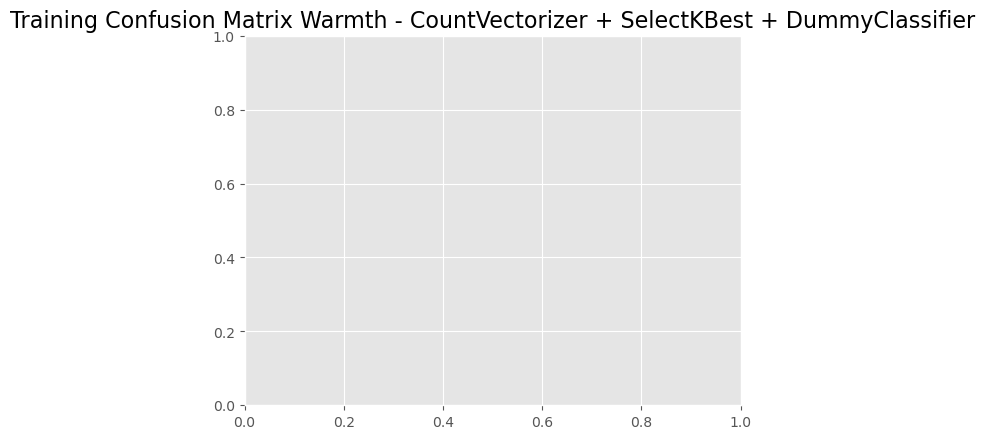

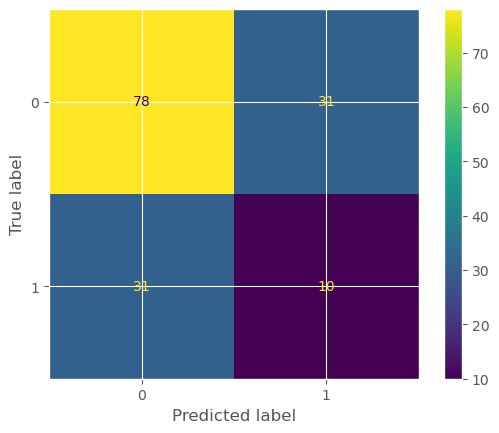

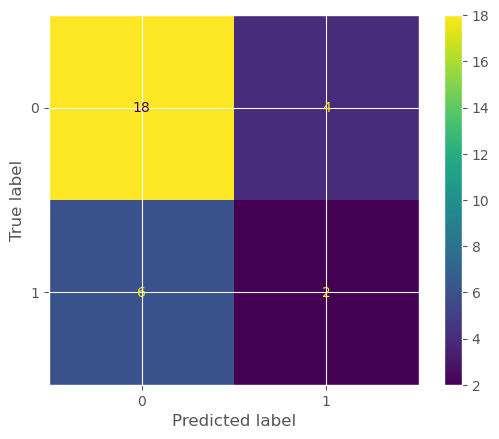

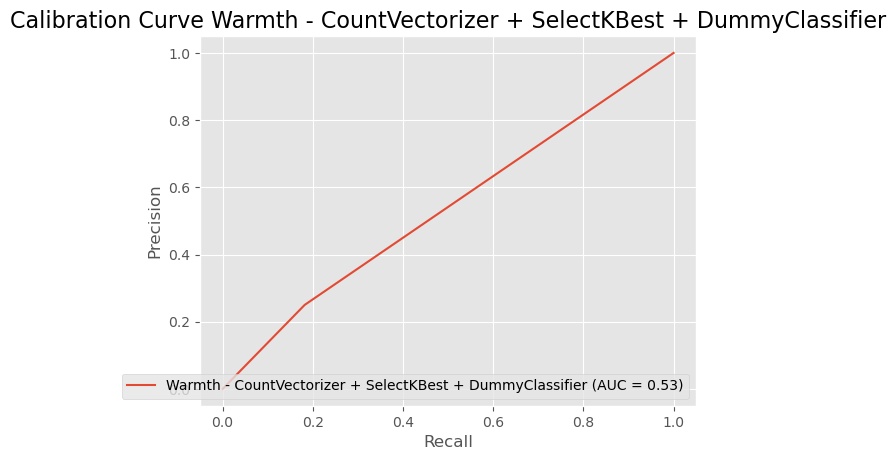

In [17]:
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

table_df = make_table_df(vectorizers_pipe, selectors_pipe, classifiers_pipe, analysis_columns, metrics_list)

for col in analysis_columns:

    print('-'*20)
    print(f'{"="*30} TRAINING {col.upper()} {"="*30}')
    print('-'*20)

    if (len(df_manual[df_manual[str(col)].map(df_manual[str(col)].value_counts() > 1)]) != 0):

        # BOW Split
        train, X_train, y_train, test, X_test, y_test, validate, X_validate, y_validate = split_data(df_manual, col, text_col = text_col)

        for col, (vectorizer_name, vectorizer_and_params), (selector_name, selector_and_params), (classifier_name, classifier_and_params) in itertools.product(analysis_columns, vectorizers_pipe.items(), selectors_pipe.items(), classifiers_pipe.items()):

            vectorizer = vectorizer_and_params[0]
            vectorizer_params = vectorizer_and_params[1]

            selector = selector_and_params[0]
            selector_params = selector_and_params[1]

            classifier = classifier_and_params[0]
            classifier_params = classifier_and_params[1]

            # Pipeline
            ## Steps
            steps = [
                (vectorizer_name, vectorizer),
                (selector_name, selector),
                (classifier_name, classifier)
            ]

            ## Params
            param_grid = {
                **vectorizer_params,
                **selector_params,
                **classifier_params,
            }

            ## Pipeline
            pipe = Pipeline(steps=steps)

            # Search
            print('-'*20)
            print(f'{"="*30} Using GridSearchCV {"="*30}')
            print('-'*20)
            print(f'GridSearchCV with:\nPipe:\n{pipe}\nParams:\n{param_grid}')
            print('+'*30)
            search = GridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                n_jobs=-1,
                scoring=scores,
                cv=cv,
                refit=scores[0],
                return_train_score=True,
            )

            # Fit SearchCV
            searchcv = search.fit(X_train, y_train)

            # Best Parameters
            best_index = searchcv.best_index_
            cv_results = sorted(searchcv.cv_results_)
            best_params = searchcv.best_params_
            best_score = searchcv.best_score_
            n_splits = searchcv.n_splits_
            estimator = searchcv.best_estimator_
            y_train_pred = estimator.predict(X_train)

            vectorizer = estimator[0]
            vectorizer_name = vectorizer.__class__.__name__
            selector = estimator[1]
            selector_name = selector.__class__.__name__
            classifier = estimator[2]
            classifier_name = classifier.__class__.__name__

            print('=' * 20)
            print(f'Best index for {scores[0]}: {best_index}')
            print(f'Best estimator for {scores[0]}: {estimator}')
            print(f'Best params for {scores[0]}: {best_params}')
            print(f'Best score for {scores[0]}: {best_score}')
            print(f'Number of splits for {scores[0]}: {n_splits}')

            print('-' * 20)
            train_report = classification_report(y_train, y_train_pred)
            print(f'Training Classification Report:\n{train_report}')
            print(f'Training Confusion Matrix:')
            plt.title(
                f'Training Confusion Matrix {str(col)} - {vectorizer_name} + {selector_name} + {classifier_name}', fontsize=16
            )
            train_cm = metrics.ConfusionMatrixDisplay.from_estimator(
                estimator, X_train, y_train
            ).plot(xticks_rotation='vertical', cmap=plt.cm.Blues)
            plt.clf()
            plt.cla()
            plt.close()
            print('=' * 20)

            # Make the predictions
            if hasattr(searchcv, 'predict_proba'):
                searchcv_predict_attr = searchcv.predict_proba
            elif hasattr(searchcv, '_predict_proba_lr'):
                searchcv_predict_attr = searchcv._predict_proba_lr
            score = searchcv.score(X_test, y_test)
            y_test_pred = searchcv.predict(X_test)    
            y_test_pred_prob = searchcv_predict_attr(X_test)[:, 1]
#             y_validate_pred = searchcv.predict(X_validate)
            y_validate_pred_prob = searchcv_predict_attr(X_validate)[:, 1]
            y_validate_pred = y_validate_pred_prob

            # Fit Best Model
            print(f'Fitting {estimator}.')
            estimator.set_params(**estimator.get_params())
            estimator = estimator.fit(X_train, y_train)

            # Evaluate Model
            table_df, mean_validation_score, explained_variance, accuracy, precision, recall, f1, mcc, loss, report, cm, cm_normalized = evaluation(
                estimator, col, vectorizer_name, selector_name, classifier_name, X_validate, y_validate, y_validate_pred, y_validate_pred_prob, best_score, scoring
            )

            # Save Vectorizer, Selector, and Classifier
            saving_model_and_table(col, table_df, estimator, vectorizer_name, selector_name, classifier_name)

print('#'*40)
print('DONE!')
print('#'*40)


In [ ]:
print('yes')